# Diffusion

In this notebook you will:
- Analyze one-dimensional diffusion
- Evolve a step function initial condition (and others)
- Investigate in/stability of forward and backward Euler algorithms
- Compare with analytic solution
- Investigate position-dependent diffusion constant: e.g. $D = D_0 \exp(- |x| / \lambda)$
- Try to solve this new problem analytically

In a nutshell:
- ...

For the future:
- ...

Resources:
- http://hplgit.github.io/num-methods-for-PDEs/doc/pub/diffu/sphinx/._main_diffu001.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.linalg
import copy

%matplotlib inline

# Diffusion equation

# $\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial^2 x}$

Diffusion equation

Common model applied to many things including heat flow, chemical mixing,

### RICHARD: Should we derive the numberical methods?

### TRY:
Understand and explain the intuition behind this equation.

# Forward Euler method

In [2]:
def diffusion_step_forward_euler(c, D, dx, dt, boundary_conditions=None):
    
    # Create dimensionless coefficient cluster.
    F = D*dt/(dx**2)
    
    c_new = np.zeros(c.shape)
    
    # Update interior points.
    for i in range(1, Nx - 1):
        c_new[i] = c[i] + F*(c[i - 1] - 2 * c[i] + c[i + 1])
    
    # Impose boundary conditions.
    if boundary_conditions is None:
        boundary_conditions = [0, 0]
        
    c_new[0] = boundary_conditions[0]
    c_new[-1] = boundary_conditions[1]
    
    return c_new

In [3]:
def setup_space_and_time(L, Nx, T, Nt):

    # Discretize space
    L = 10 # spatial extent
    Nx = 100 # number of spatial grid points - including boundaries
    xs = np.linspace(0, L, Nx)
    dx = xs[1] - xs[0]

    # Discretize time
    T = 1 # total time of evolution
    Nt = 100 # number of time grid points - including initial and final times
    ts = np.linspace(0, T, Nt)
    dt = ts[1] - ts[0]
    
    return xs, dx, ts, dt

In [4]:
# Diffusion constant
D = 0.2

# Set up our discrete space and time
L = 10
Nx = 100
T = 1
Nt = 100
xs, dx, ts, dt = setup_space_and_time(L=L, Nx=Nx, T=T, Nt=Nt)

# Create initial condition
c = np.zeros(Nx)

# Plateau
c[Nx//3:Nx//2] = 1 

# # Random
# c = np.random.random(c.shape)

# # Gaussian
# mu= L/3
# sigma = L/10
# a = 1
# c = (a / (sigma*(2*np.pi)**0.5)) * np.exp( -(1/2)*(xs - mu)**2 / sigma**2 )

# Set BCs
bcs = [0, 0]

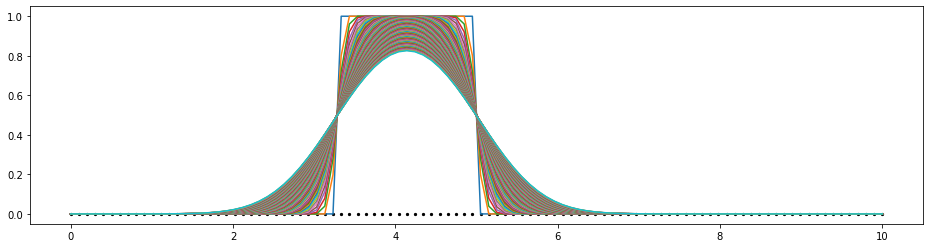

In [5]:
fig = plt.figure(figsize=(16, 4))
plt.scatter(xs, 0*xs, s=5, c='k')
plt.plot(xs, c)

for tind in range(1, Nt):
    c = diffusion_step_forward_euler(c, D, dx, dt, boundary_conditions=bcs)

    if tind % 1 == 0:
        plt.plot(xs, c)

In [ ]:
# TRY: What happens as you rerun (many times) the above cell (without resetting the IC)?

In [6]:
# TRY: Try evolving a random IC. How many steps does it take to become smooth looking?
# Define a reasonable metric to quantify this smoothness.
# Start with the random IC and plot the evolution of this metric over time.

In [7]:
# TRY: What happens when we set the boundary conditions to something other than [0, 0]?
# By iterating several times can you guess the asymptotic solution?

In [8]:
# Sometimes we observe oscillations in the evolved function c[x]. What's going on here?
# You should be able to find this behavior by just making Nx larger by a factor of 10 or so.

# TRY: Find a small T where there is no oscillation, and a high T where there is. Zoom in on the critical value of T.
# Can you get any insight into what is happening in the algorithm?
# Try a few different initial conditions: linear, gaussian,.. - does this instability depend on the sharp edges of the IC?
# Explore a bit more.
# If you change dx, does the critical value of dt change?
# Make a hypothesis about what might be a critical value of F.

In [9]:
# TRY: Is the "stuff" conserved by this scheme?
# To the above simulation, add a second axes (using plt.subplots) that shows total "stuff" vs iteration.

In [10]:
# TODO: 
# Implement analytic solution.

In [11]:
# Look at a quadratic initial condition - What do we notice?

# Diffusion constant
D = 0.2

# Set up our discrete space and time
L = 10
Nx = 100
T = 1
Nt = 100
xs, dx, ts, dt = setup_space_and_time(L=L, Nx=Nx, T=T, Nt=Nt)

# Create initial condition
c = np.zeros(Nx)

# Quadratic
left_root_ind = Nx//5
right_root_ind = 2*Nx//3
quad_func = lambda x: -1*(x - xs[left_root_ind]) * (x - xs[right_root_ind])

for ind in range(left_root_ind, right_root_ind + 1):
    c[ind] = quad_func(xs[ind])

# Set BCs
bcs = [0, 0]

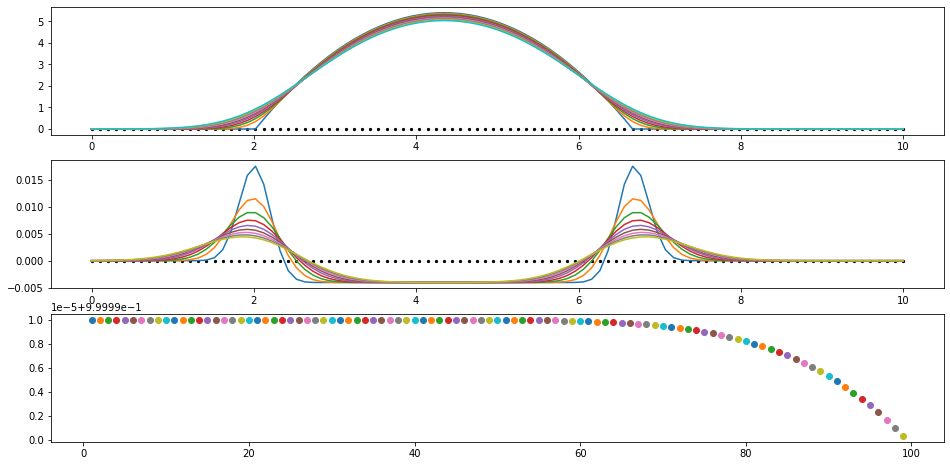

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 8))
ax[0].scatter(xs, 0*xs, s=5, c='k')
ax[1].scatter(xs, 0*xs, s=5, c='k')

ax[0].plot(xs, c)

original_mass = np.sum(c)

c_old = copy.copy(c)

for tind in range(1, Nt):
    c = diffusion_step_forward_euler(c, D, dx, dt, boundary_conditions=bcs)
    if tind % 10 == 0:
        ax[0].plot(xs, c)
        ax[1].plot(xs, c - c_old)
        
    c_old = copy.copy(c)
    
    ax[2].scatter(tind, np.sum(c)/original_mass)

In [13]:
# TRY: Add an option to the diffusion_step() function for boundary_conditions='free'. Use your intuition to come up with two different ways to implement these "free" boundary conditions. Compare your two methods - do they produce similar results?

# Backward Euler algorithm

The backward Euler algorithm differs from the forward version.
Notice that the forward algorithm updates each grid point one-by-one - independent of the rest.
In contrast, the backward algorithm performs the update in one big step by solving a set of coupled linear equations.

In [14]:
def get_A_for_backward_euler(D, dx, dt, Nx):
    
    # Create dimensionless coefficient cluster.
    F = D*dt/(dx**2)
    
    # Data structures for the linear system
    A = np.zeros((Nx, Nx))

    for i in range(1, Nx - 1):
        A[i, i - 1] = -F
        A[i, i + 1] = -F
        A[i, i] = 1 + 2*F

    A[0, 0] = 1
    A[Nx - 1, Nx - 1] = 1
    
    return A

def diffusion_step_backward_euler(c, D, dx, dt, boundary_conditions=None, A=None):
    
    if A is None:
        A = get_A_for_backward_euler(D, dx, dt, Nx)
        
    # Create dimensionless coefficient cluster.
    F = D*dt/(dx**2)
    
    c_new = np.zeros(c.shape)
    
    # Set boundary conditions
    if boundary_conditions is None:
        boundary_conditions = [0, 0]
    
    c[0] = boundary_conditions[0]
    c[-1] = boundary_conditions[1]
    
    # Compute new configuration.
    c_new[:] = scipy.linalg.solve(A, c)
    
    return c_new

In [15]:
# Diffusion constant
D = 0.2

# Set up our discrete space and time
L = 10
Nx = 100
T = 2
Nt = 200
xs, dx, ts, dt = setup_space_and_time(L=L, Nx=Nx, T=T, Nt=Nt)

# This is like the "update" matrix for the backward Euler method.
A = get_A_for_backward_euler(D, dx, dt, Nx)

# Gaussian
mu= L/3
sigma = L/10
a = 1
c = (a / (sigma*(2*np.pi)**0.5)) * np.exp( -(1/2)*(xs - mu)**2 / sigma**2 )

# Set BCs
bcs = [0.6, 0.2]

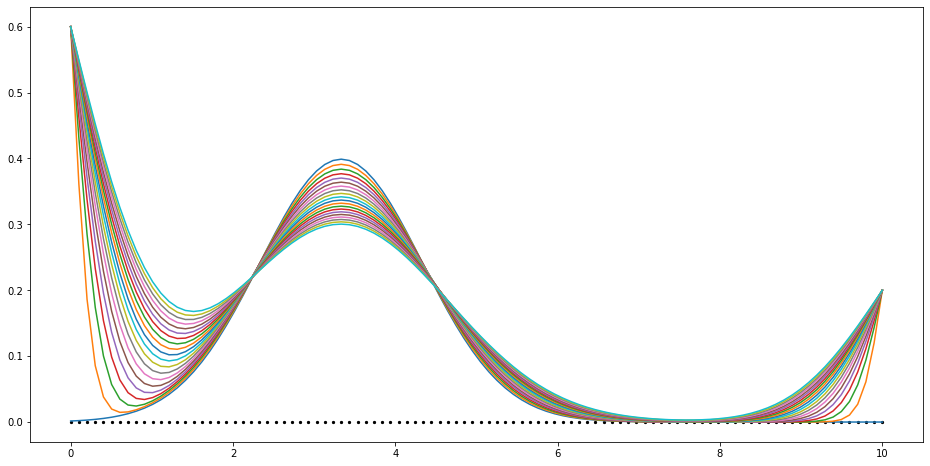

In [16]:
fig = plt.figure(figsize=(16, 8))
plt.scatter(xs, 0*xs, s=5, c='k')
plt.plot(xs, c)

for tind in range(1, Nt):
    c = diffusion_step_backward_euler(c, D, dx, dt, boundary_conditions=bcs, A=A)

    if tind % 10 == 0:
        plt.plot(xs, c)

In [17]:
# TRY: 
# Look more closely at the inflection points of the IC.
# Are they constant in time?

# TRY:
# Do all points evolve in a monotonic fashion?
# If so, why?
# If not, can you construct an IC where this is clearly not true?
# And can you place bounds on the number of direction changes (maybe based on the IC)?

In [29]:
# TRY:
# Test out the stability of the backward Euler method by looking for transitions in behavior.
# Find a set of parameters for which the forward euler displays mildly unstability and the backward euler is stable.
# Plot these two simulations together.

# RICHARD: the backward Euler method is always stable. Can we provide intuition or a proof?

In [19]:
# Are we getting something for nothing? 
# Let's investigate the time-complexity of the two algorithms using some sample runs.

In [20]:
# First, let's learn a little about timing code in python.

# Create some toy functions to learn about timing code.

# TRY: Understand what these functions do and describe how they do it (how they are different).

def slow_func(x):
    y = []
    for xx in x:
        if xx > 0:
            y.append(xx)
    return y

def medium_func(x):
    return [xx for xx in x if xx > 0]

def fast_func(x):
    mask = (x > 0)
    return x[mask]

In [21]:
# Now we can compare these three functions using "a python magic function".
# This gives us nice information about the code chunk with a lot of convenience built in.

# NOTE: The syntax for these magic functions is somewhat strange - they are prepended by '%' and they do not use function parentheses - these calls look more like UNIX.

x = np.random.random(10**3)
%timeit slow_func(x)
%timeit medium_func(x)
%timeit fast_func(x)

539 µs ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
471 µs ± 31.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.61 µs ± 114 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [22]:
# If we want to gather the output of the various timings (for a plot or analysis), we could do this:
# Since there is variability in timing, we often want some statistics.
# The parameters '-n' and '-r' set the number of repetitions and number of batches used for these statistics.

# NOTE: '-o' generates the output object. 

# TRY: Observe what happens when you modify 'n' and 'r'. Does the behavior make sense?
result = %timeit -o -n 100 -r 10 fast_func(x)

8.48 µs ± 4.25 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [23]:
# TRY: Explore the various attributes of this result object.
result.average

8.480187039822341e-06

size =  1
2.25 µs ± 161 ns per loop (mean ± std. dev. of 10 runs, 1000 loops each)
2.63 µs ± 523 ns per loop (mean ± std. dev. of 10 runs, 1000 loops each)
4.44 µs ± 524 ns per loop (mean ± std. dev. of 10 runs, 1000 loops each)
size =  2
3.59 µs ± 440 ns per loop (mean ± std. dev. of 10 runs, 1000 loops each)
2.69 µs ± 136 ns per loop (mean ± std. dev. of 10 runs, 1000 loops each)
4.39 µs ± 838 ns per loop (mean ± std. dev. of 10 runs, 1000 loops each)
size =  4
4.55 µs ± 753 ns per loop (mean ± std. dev. of 10 runs, 1000 loops each)
4.24 µs ± 538 ns per loop (mean ± std. dev. of 10 runs, 1000 loops each)
4.6 µs ± 611 ns per loop (mean ± std. dev. of 10 runs, 1000 loops each)
size =  8
6.96 µs ± 1.02 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)
5.69 µs ± 899 ns per loop (mean ± std. dev. of 10 runs, 1000 loops each)
4.5 µs ± 756 ns per loop (mean ± std. dev. of 10 runs, 1000 loops each)
size =  16
11.7 µs ± 1.08 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


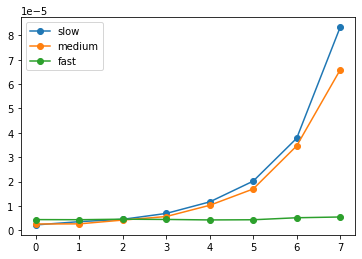

In [24]:
# Now we can put this information together to do a more detailed analysis of the three toy functions.

slow_ts = []
medium_ts = []
fast_ts = []

sizes = 2**np.arange(0, 8)
for size in sizes:
    print("size = ", size)
    xs = np.random.random(size)
    
    result = %timeit -o -n 1000 -r 10 slow_func(xs)
    slow_ts.append(result.average)
    result = %timeit -o -n 1000 -r 10 medium_func(xs)
    medium_ts.append(result.average)
    result = %timeit -o -n 1000 -r 10 fast_func(xs)
    fast_ts.append(result.average)
    
plt.plot(slow_ts, 'o-', label='slow')
plt.plot(medium_ts, 'o-', label='medium')
plt.plot(fast_ts, 'o-', label='fast')
plt.legend()

In [25]:
%%timeit -o #-n 1000 -r 10
x = np.linspace(0,10,100)
y = x**2
z = np.sin(y)
fast_func(x)

# The timeit "magic" also operates in a "cell-mode".

78.9 µs ± 2.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<TimeitResult : 78.9 µs ± 2.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)>

In [26]:
# cell-mode requires that you grab the result in this way - not beautiful..
result = _
print(result.average)

7.891531944291533e-05


In [30]:
# We can also solve the problem using the module 'time'.
# It is less sophisticated and less accurate, but somewhat more straightforward to work with in some contexts.
# We can use it to drop in "clock markers" in our code.

import time

D = 0.2

# Set up our discrete space and time
L = 10
Nx = 100
T = 1
Nt = 1000
xs, dx, ts, dt = setup_space_and_time(L=L, Nx=Nx, T=T, Nt=Nt)

# Set BCs
bcs = [0, 0]

clock_times = []

### Forward euler
# Create initial condition
c = np.zeros(Nx)
c[Nx//3:Nx//2] = 1 # Plateau

clock_times.append(time.clock())
for tind in range(1, Nt):
    c = diffusion_step_forward_euler(c, D, dx, dt, boundary_conditions=bcs)
        
clock_times.append(time.clock())

### Backward euler
A = get_A_for_backward_euler(D, dx, dt, Nx)
# Create initial condition
c = np.zeros(Nx)
c[Nx//3:Nx//2] = 1 # Plateau

clock_times.append(time.clock())
for tind in range(1, Nt):
    c = diffusion_step_backward_euler(c, D, dx, dt, boundary_conditions=bcs, A=A)
        
clock_times.append(time.clock())
###

clock_times = np.array(clock_times)
print(np.diff(clock_times))

[2.054750e-01 4.130000e-04 6.079545e+00]


In [31]:
# TRY: Does the computation time depend on F?
# In Euler forward it seems that as long as the computation is not going unstable, the time should be independent of F. Confirm this.
# In Euler backward, because we are solving a couple system of equations, it seems possible that some values of F might lead to ill-conditioned LA problems and these might take longer for various solvers to converge. What do you find?

# Position dependence

# $\frac{\partial C}{\partial t} = \frac{\partial}{\partial x}(D \frac{\partial C}{\partial x})$

What happens when the diffusion "constant" depends on position?

Maybe go through derivation of diffusion equation?
Or maybe just motivate why the partial derivative includes $D$.

In [ ]:
# CHALLENGE:
# Imagine that this 1D array represents a metal rod at some uniform temperature $T_0$.
# We may apply a heat source (at fixed $T_1 > T_0$), but only to one end at a time.
# We may also pause the application and apply no heat.
# CHALLENGE: Can you devise a heating protocol that will 